In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [2]:
cd C:\Users\vlad\1. Machine Learning\Yandex Specialization\5.Applied Tasks Of Data Analysis\week1\data

C:\Users\vlad\1. Machine Learning\Yandex Specialization\5.Applied Tasks Of Data Analysis\week1\data


**1)** Визуализировать временной ряд. Данные по ежемесячному уровню производства молока в фунтах на одну корову

In [46]:
data = pd.read_csv('monthly-milk-production.csv', sep=';', index_col=['month'], parse_dates=['month'], dayfirst=True)
data.head()

,milk
month,
1962-01-01,589
1962-02-01,561
1962-03-01,640
1962-04-01,656
1962-05-01,727


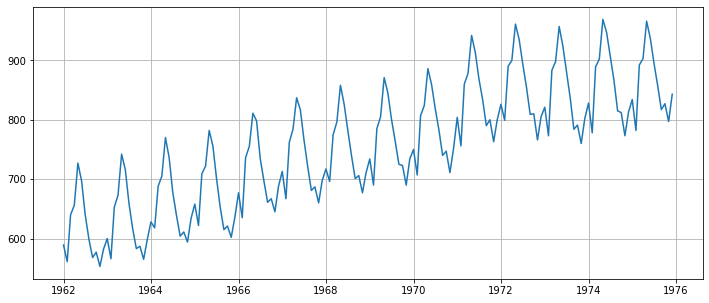

In [47]:
def plot_ts(series):
    plt.figure(figsize=(12,5))
    plt.grid(True)
    plt.plot(series);

plot_ts(data['milk'])

**2)** Примените к ряду из предыдущего вопроса критерий Дики-Фуллера. Чему равен полученный достигаемый уровень значимости? Округлите до двух знаков после десятичной точки.

In [48]:
def check_stationarity(series):
    dikki_fuller_values = sm.tsa.stattools.adfuller(series.values)
    print('Diki-Fuller p-value: %.2f' %dikki_fuller_values[1])
 
check_stationarity(data['milk'])

Diki-Fuller p-value: 0.63


Нулевая гипотеза о нестационарности временного ряда не отвергается. **Ряд нестационарный.**

**3)** Часто, когда вы имеете дело с величинами, представляющими собой сумму значений показателя за каждый день или за каждый рабочий день, имеет смысл перед началом прогнозирования поделить весь ряд на число дней в периоде. Например, если поделить ряд с объёмом производства молока на одну корову на число дней в месяце, полученная величина будет меняться более плавно, и для неё легче будет построить прогнозирующую модель.

Корректно определить число дней в месяце можно с помощью свойства ```days_in_month``` у индекса ряда или функции ```monthrange``` из пакета ```calendar.```

Используйте число дней в месяце для того, чтобы вычислить новый показатель — **среднее дневное число полученного молока на одну корову.** Постройте график этого ряда и убедитесь, что он стал более гладким.

В качестве ответа введите сумму значений полученного показателя за весь период; округлите до двух знаков после десятичной точки.

In [49]:
# Найдем число дней в месяце
data['days_in_month'] = data.index.days_in_month

# Получим среднее дневное число полученного молока на одну корову
data['milk_per_day'] = data['milk']/data['days_in_month']

In [50]:
res = round(data['milk_per_day'].sum(), 2)
res

4166.33

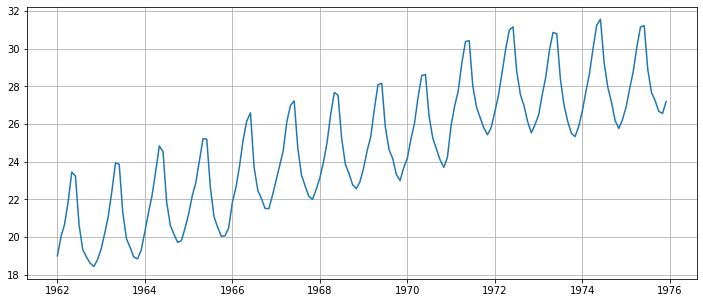

In [51]:
# Визуализируем
plot_ts(data['milk_per_day'])

**4)** Для ряда со средним дневным количеством молока на корову из предыдущего вопроса давайте с помощью критерия Дики-Фуллера подберём порядок дифференцирования, при котором ряд становится стационарным. 

Дифференцирование можно делать так:

```milk.daily_diff1 = milk.daily - milk.daily.shift(1)```

Сезонное Диффиринцирование:

```milk.daily_diff12 = milk.daily - milk.daily.shift(12)```

In [52]:
# Метод shift позволяет сдвинуть ряд на 1 значение вперед
data['milk_per_day'].shift(1)

month
1962-01-01          NaN
1962-02-01    19.000000
1962-03-01    20.035714
1962-04-01    20.645161
1962-05-01    21.866667
                ...    
1975-08-01    28.903226
1975-09-01    27.677419
1975-10-01    27.233333
1975-11-01    26.677419
1975-12-01    26.566667
Name: milk_per_day, Length: 168, dtype: float64

In [53]:
# Применим дифференцирование ряда
ts_dif_1 = data['milk_per_day'] - data['milk_per_day'].shift(1)

# Применим сезонное дифференцирование (длина сезона 12 месяцев)
ts_dif_2 = data['milk_per_day'] - data['milk_per_day'].shift(12)

Нужно помнить, что чем меньше мы дифференцируем ряд, тем лучше, и что если мы имеем сезонную компоненту, то первым делом необходимо применить сезонные разности.

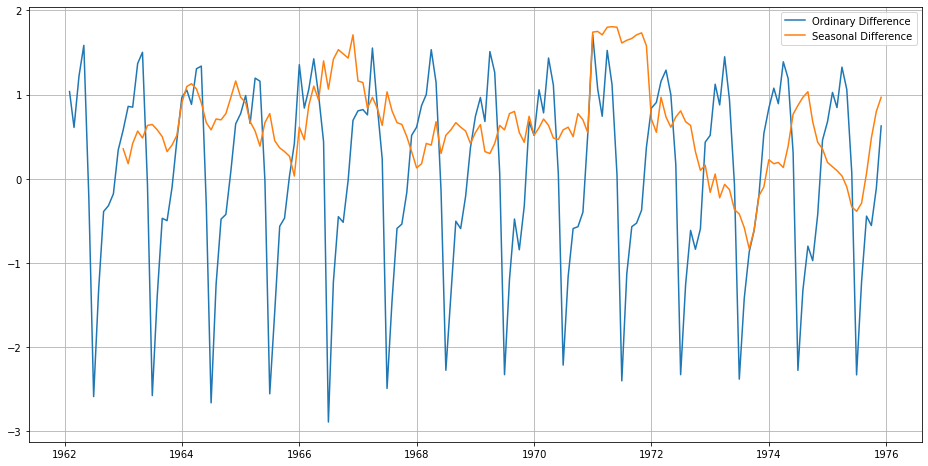

In [54]:
plt.figure(figsize=(16, 8))
plt.plot(ts_dif_1, label='Ordinary Difference')
plt.plot(ts_dif_2, label='Seasonal Difference')
plt.grid(True)
plt.legend();

При дифференцировании длина ряда сокращается, поэтому в части строк в новой колонке значения будут не определены (NaN). Подавая полученные столбцы на вход критерию Дики-Фуллера, отрезайте неопределённые значения, иначе вы получите неопределённый достигаемый уровень значимости. 

In [55]:
# Проверяем стационарность рядов, незабываем отрезать NaN values
print('Ordinary Difference')
check_stationarity(ts_dif_1[1:])
print()
print('Seasonal Difference')
check_stationarity(ts_dif_2[12:])

Ordinary Difference
Diki-Fuller p-value: 0.06

Seasonal Difference
Diki-Fuller p-value: 0.22


Видно, что не одно из дифференцирований не приводит к стационарности. Нужно спользовать несколько дифференцирований подряд. Иcпользуем сезонное, затем обычное дифференцирование.

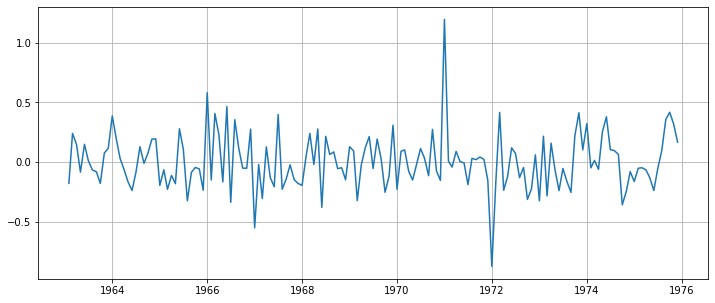

In [56]:
ts_dif_1 = data['milk_per_day'] - data['milk_per_day'].shift(12)
ts_dif_2 = ts_dif_1 - ts_dif_1.shift(1)

plot_ts(ts_dif_2)

График показывает, что ряд стационарный, проверим формально, используя критерий Дики-Фуллера

In [57]:
check_stationarity(ts_dif_2[13:])

Diki-Fuller p-value: 0.00


Действитеьно, ряд является стационарным. Ради эксперимента проверим, сколько раз необходимо продифференицровать ряд обычными разностями.

In [61]:
ordinary_diff = data['milk_per_day'] - data['milk_per_day'].shift(1)
check_stationarity(ordinary_diff[1:])

ordinary_diff = ordinary_diff - ordinary_diff.shift(1)
check_stationarity(ordinary_diff[2:])

Diki-Fuller p-value: 0.06
Diki-Fuller p-value: 0.00


Видно, что необходимо 2 разности. Однако на графике явно видно сезонные компоненты, которых нет в случае применения сезонных разностей. Далее будем использовать ```ts_dif_2```

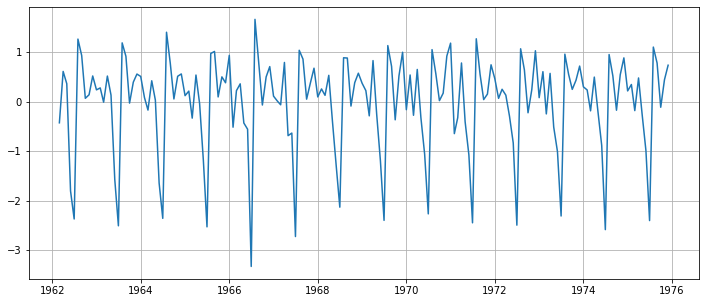

In [62]:
plot_ts(ordinary_diff)

**5)** Для стационарного ряда из предыдущего вопроса (продифференцированного столько раз, сколько вы посчитали нужным) постройте график автокорреляционной функции. Это можно cделать так:

``` import statsmodels.api as sm```

```sm.graphics.tsa.plot_acf(ряд.values.squeeze(), lags=50)```

```NaN``` **значения должны быть убраны**

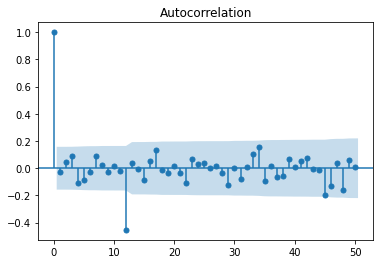

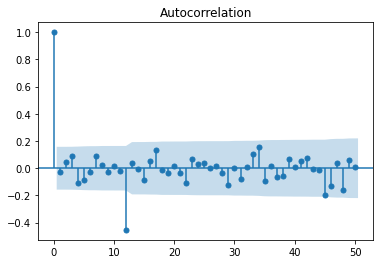

In [72]:
import statsmodels.api as sm

sm.graphics.tsa.plot_acf(ts_dif_2[13:].values.squeeze(), lags=50)

Исходя из этого графика, какое начальное приближение вы предложили бы для параметра ```Q``` в модели SARIMA?

Длина сезонной компоненты 12. На графике видно, что значимый лаг 12, потому параметры Q можно определить как **12 или 1**

**6)** Для того же ряда, что и в предыдущем вопросе, постройте график частичной автокорреляционной функции. Это можно сделать так:

```import statsmodels.api as sm```

```sm.graphics.tsa.plot_pacf(ряд.values.squeeze(), lags=50)```

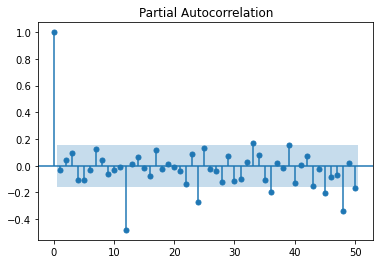

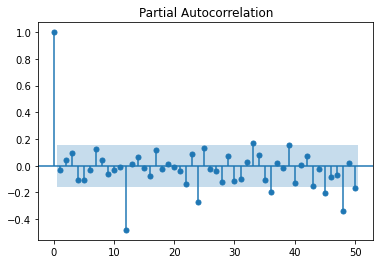

In [74]:
sm.graphics.tsa.plot_pacf(ts_dif_2[13:].values.squeeze(), lags=50)

Исходя из этого графика, какое начальное приближение вы предложили бы для параметра ```p``` в модели SARIMA?

Можно заметить, что есть значимые лаги такие как 33, 39, 43, 45. Однако их величины слишком большие и мы не должны забывать эвристику p < S (т.е. p < 12). В нашем случае, мы не наблюдаем значимых лагов при p < 12. Начальное приближение 0.